# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la

%matplotlib inline


## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [2]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [3]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k])
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set


In [3]:
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

In [6]:
# Preliminary questions

cov = np.cov(data_train[:,:9].T, bias = True) # the autocovariance matrix
print(np.round(cov,3))

[[ 1.     0.3    0.286  0.063  0.593  0.692  0.426  0.483  0.879]
 [ 0.3    1.     0.317  0.437  0.181  0.157  0.024  0.074  0.582]
 [ 0.286  0.317  1.     0.287  0.129  0.173  0.366  0.276  0.273]
 [ 0.063  0.437  0.287  1.    -0.139 -0.089  0.033 -0.03   0.315]
 [ 0.593  0.181  0.129 -0.139  1.     0.671  0.307  0.481  0.668]
 [ 0.692  0.157  0.173 -0.089  0.671  1.     0.476  0.663  0.586]
 [ 0.426  0.024  0.366  0.033  0.307  0.476  1.     0.757  0.41 ]
 [ 0.483  0.074  0.276 -0.03   0.481  0.663  0.757  1.     0.537]
 [ 0.879  0.582  0.273  0.315  0.668  0.586  0.41   0.537  1.437]]


The autocovariance matrix is symetric but not diagonal. The variables (entries) aren't really independent.
-
-
-
-
les variables les + corrélées

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [6]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

In [7]:
# Exercise 1
t_train = data_train[:,8]   # target column
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:,0:8]), axis=1) 

beta_hat = (np.linalg.inv((X_train.T).dot(X_train)).dot(X_train.T)).dot(t_train)

# beta_hat[0] = 2.45 is the bias

Els1 = np.linalg.norm(X_test.dot(beta_hat)-t_test)**2 # Quadratic error from the test set
print(Els1)

NameError: name 'X_test' is not defined

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [42]:
# Exercise 2
#1
X = M_train[:,0:8]

t_hat = X_train.dot(beta_hat) #t_hat extracted from the training set

sigma_hat = np.sqrt((t_hat-t_train).dot((t_hat-t_train).T)/(67-8-1))

nu = np.diag(inv(X.T.dot(X)))

Z = np.array([beta_hat[j+1]/(sigma_hat*np.sqrt(nu[j])) for j in range(8)])

#Z_ = np.array(np.abs(Z)>2, dtype = int) # Returns 0 if |Zj|<2 and 1 if not

#beta_hat_rej = np.array([beta_hat[0]]+[Z_[j]*beta_hat[j+1] for j in range(8) ]) 


beta_hat_rej = np.append(beta_hat[0], [beta_hat[i+1] if abs(z)>2 else 0 for i,z in enumerate(Z)])
#2
Els_rej = np.linalg.norm(X_test.dot(beta_hat_rej)-t_test)**2 # Quadratic error from the test set with rejection test
print(Els_rej)
print(beta_hat_rej)


13.5667984822
[ 2.45234509  0.71104059  0.29045029  0.          0.21041951  0.30730025
  0.          0.          0.        ]


# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [43]:
t = data_train[:,8]   # column of targets
t0 = np.mean(t)

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)),M_test[:,0:8]))

# Here the 1st column of X_test is a column of ones.
#t_hat_reg = X_test.dot(beta_hat_reg)

Els regularized:  14.8182647974
Els best:  14.8106010333


<Container object of 9 artists>

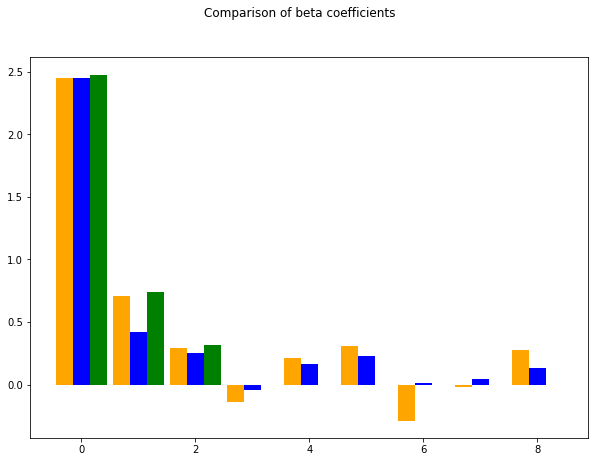

In [53]:
# Exercise 3
#1
y = 25
X_c = M_train[:,0:8]
t_c = t-t0

beta_hat_reg=np.zeros(9)
beta_hat_reg[0]=t0

beta_hat_reg[1:] = (np.linalg.inv(y*np.identity(8)+X_c.T.dot(X_c)).dot(X_c.T)).dot(t_c) #the regression vector

beta_best = np.array([2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0])

#2
Els2 = np.linalg.norm(X_test[:,1:].dot(beta_hat_reg[1:])-(t_test-t0))**2 # Quadratic error from the test set
print("Els regularized: ", Els2)

Els3 = np.linalg.norm(X_test.dot(beta_best)-t_test)**2 # Quadratic error from the test set
print("Els best: ",Els3)

fig = plt.figure(figsize=(10,7))
fig.suptitle('Comparison of beta coefficients')
x= np.linspace(0,8,9)
ax = plt.subplot(111)
ax.bar(x-0.3,beta_hat, width=0.3, color='orange') #Color : orange
ax.bar(x,beta_hat_reg, width=0.3, color='b') #Color : blue
ax.bar(x+0.3,beta_best, width=0.3, color='g') #Color : green



# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` rangin from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [45]:
X_train.shape

(67, 9)

In [67]:
lmax = 40
lambda_pos = arange(0,lmax+1) 

N_test = 10
m=np.zeros(8)
s = np.zeros(8)
X_traink = np.zeros((X_train.shape[0]-N_test,8))
X_testk = np.zeros((N_test,8))
err=np.zeros((6, lmax+1))

In [81]:
# Exercise 4 
L = np.arange(data_train.shape[0])
np.random.shuffle(L) #shuffling indexes
dataTrainShuff = data_train[L] #To keep the original data_train array
for p in range(6):   # loop on test subsets
    # extraction of testset
    testset  = dataTrainShuff[p*N_test:(p+1)*N_test,0:9] 
    # extraction of trainset
    trainset = dataTrainShuff[hstack((arange(p*N_test),arange((p+1)*N_test,dataTrainShuff.shape[0]))),0:9] 
    # normalization of entries.
    trainsetN = np.array([ normalize(vec) for vec in trainset[:,0:8].T ]).T #entries normalized
    for y in lambda_pos:
        beta = np.zeros(9)
        beta[0]= np.mean(trainset[:,8]) 
        beta[1:] = (np.linalg.inv(y*np.identity(8)+trainsetN.T.dot(trainsetN)).dot(trainsetN.T)).dot(trainset[:,8])
        err[p,y] = np.linalg.norm(testset[:,1:].dot(beta[1:])-(testset[:,8]-np.mean(testset[:,8])))**2


[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66]
[ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 

In [61]:
data_train[:,:8].shape

(67, 8)

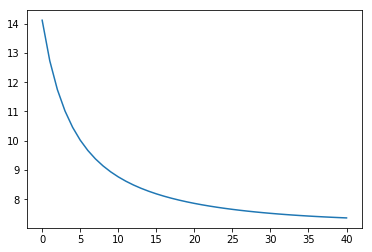

In [56]:
# Exercise 4 ---------------
# ...
err_mean = np.array([np.mean([err[:,i]]) for i in lambda_pos])

plot(lambda_pos, err_mean)
# averaged error on the 6 training/test sets ?
# averaged error on the 6 training/test sets ?
# standard variation of this error estimate ?

# print(erreur_lambda, std_erreur_lambda, erreur_rel_lambda)


In [ ]:
# Exercise 4 FIGURE ---------------
# ...


In [5]:
# Exercise 4 (continued)
A = np.array([[1,2],[3,4]])
B = np.array([[5,6],[7,8]])
np.hstack((A,B))

array([[1, 2, 5, 6],
       [3, 4, 7, 8]])